In [1]:
%load_ext autoreload
%autoreload 2

from model import LitS4Model
from data import LitDataModule
from plotting import *
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
import numpy as np

In [77]:
CHECKPOINT = "/n/holystore01/LABS/iaifi_lab/Lab/creissel/neutrino_mass/trainings/WithNoiseSmallNetwork_epoch45.ckpt"

In [78]:
model = LitS4Model.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

/n/home07/hbinney/.conda/envs/ssm/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [79]:
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

/n/home07/hbinney/.conda/envs/ssm/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(1e-10, 1e-05)

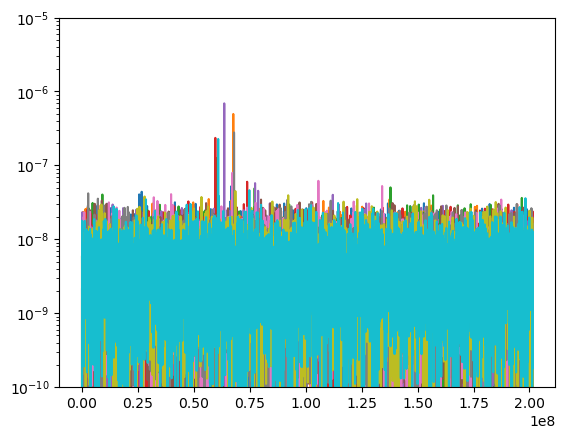

In [80]:
# Just plotting some FFTs to see how tall the peaks are relative to the noise
# note that the time series have been normalized by the amplitudes so noise amplitudes will be slightly different
from scipy import signal
import matplotlib.pyplot as plt
for ts,var,_ in dataset.test_dataloader():
    for i in range(10):
        f, pxx = signal.periodogram(ts[i, :, 0].numpy(), fs=403E6)
        plt.plot(f, pxx)
    break
plt.yscale('log')
plt.ylim(1E-10, 1E-5)

In [81]:
# Assumes energy and pitch are in the variables and radius is in the observables, you get the idea
energy_ind = dataset.variables.index('energy_eV')
pitch_ind = dataset.variables.index('pitch_angle_deg')
radius_ind = dataset.observables.index('radius_m')

In [82]:
from scipy.signal import find_peaks

# Get a bunch of other parameters using the time series of each event
max_powers = [] # max power of the vent
energy_errs = [] # error on the energy
summed_powers = [] # summed power above threshold

true = []
pred = []
meta = []

for ts,var,obs in dataset.test_dataloader():
    with torch.no_grad():
        
        pred.append(model(ts.to(device)).cpu().numpy())
        true.append(var.numpy())
        meta.append(obs.numpy())
        # Looping over the batches
        
        for i in range(ts.shape[0]):
            # Get the PSD for the "I" time series
            f_i, pxx_i = signal.periodogram(ts[i, :, 0].numpy(), fs=403E6)
            f_q, pxx_q = signal.periodogram(ts[i, :, 1].numpy(), fs=403E6)
            pxx_prod = pxx_i*pxx_i+pxx_q*pxx_q
            # Normalizing out the difference in noise power coming from std norm of time series
            noise_sum = np.sum(pxx_prod[:400]) # no signal in this region
            normed_pxx = pxx_prod/noise_sum
            max_powers.append(max(normed_pxx))
            summed_powers.append(np.sum(normed_pxx))

/n/home07/hbinney/.conda/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [83]:
true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
meta = np.concatenate(meta, axis=0)

In [84]:
# undo the normalization
pred_post = pred * dataset.stds + dataset.mu
true_post = true * dataset.stds + dataset.mu

In [85]:
energy_errs = true_post[:, energy_ind]-pred_post[:, energy_ind]

In [86]:
CHECKPOINT_folder = 'WithNoiseSmallNetwork_epoch45'

In [94]:
from plotting import *

WithNoiseSmallNetwork_epoch45_plots


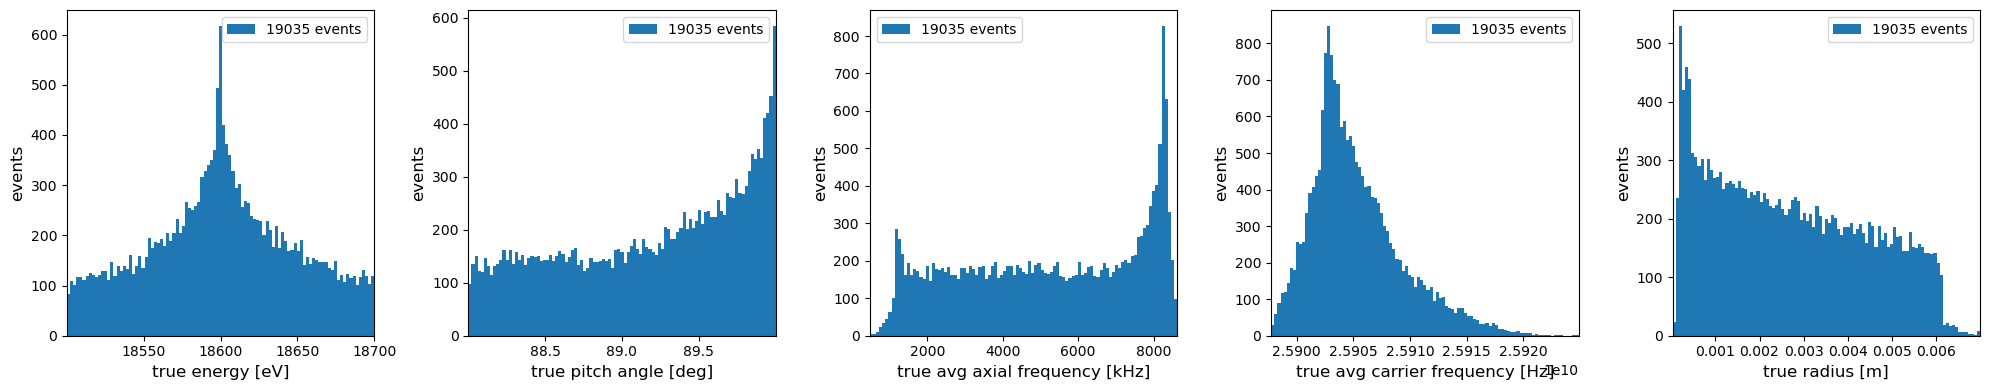

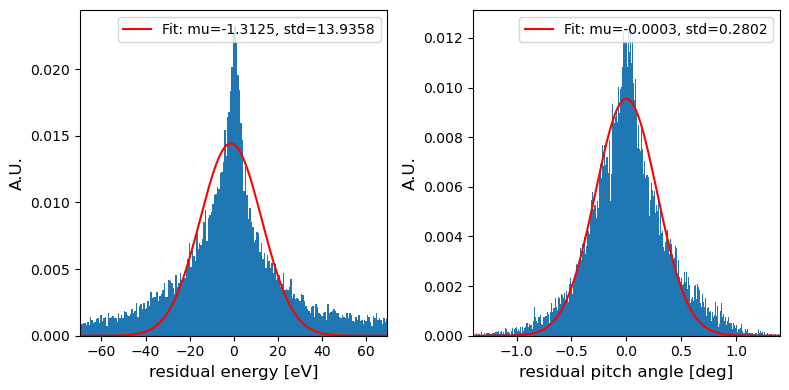

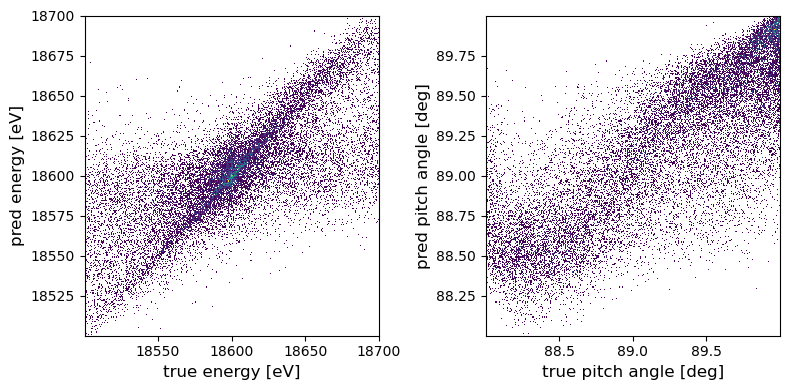

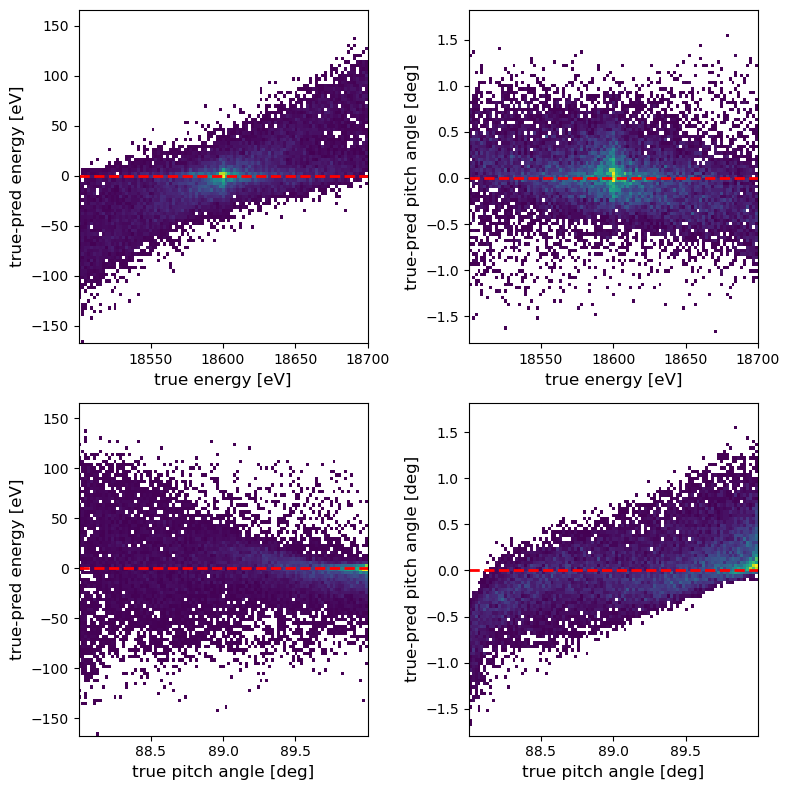

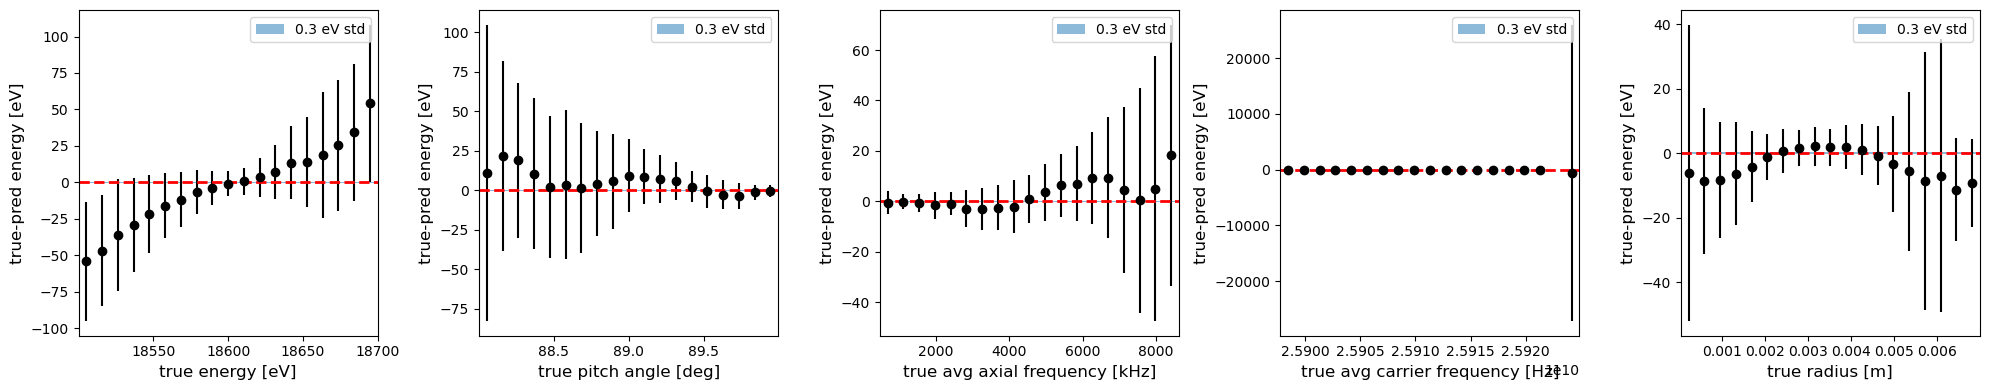

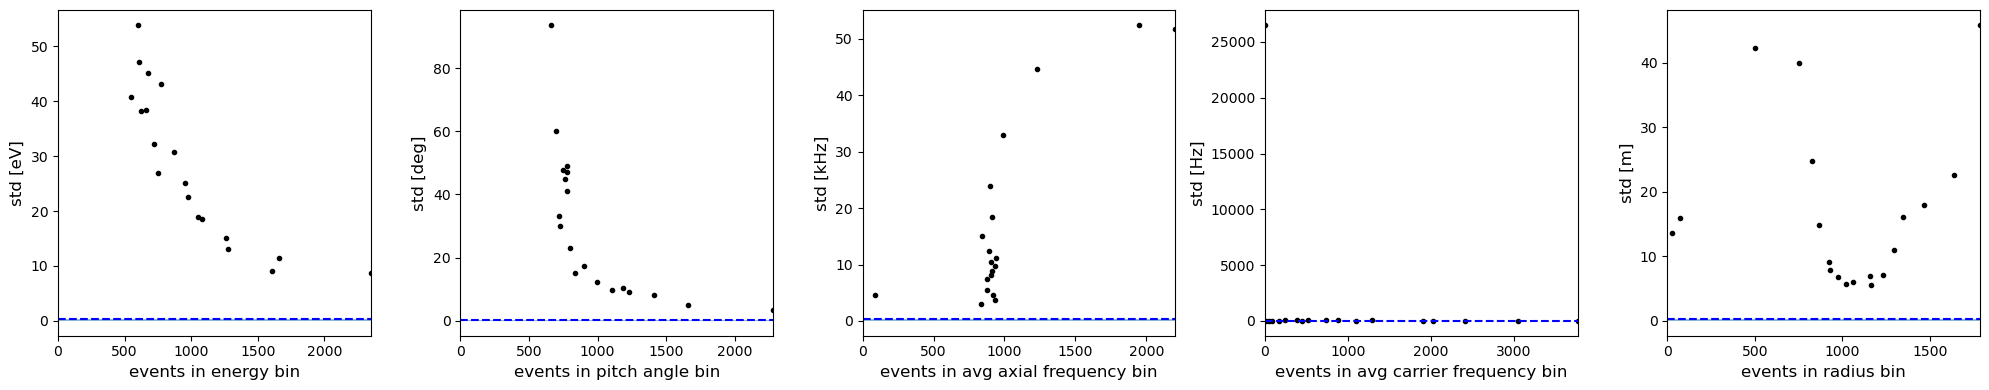

In [95]:
f = make_all_plots(dataset.variables, dataset.observables, true_post, pred_post, meta, CHECKPOINT_folder+'_plots', True)

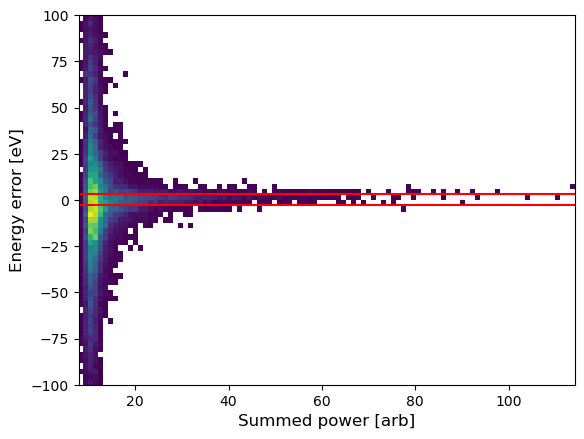

In [89]:
plt.hist2d(summed_powers, energy_errs, bins=100, cmin=1)
plt.xlabel("Summed power [arb]")
plt.ylabel("Energy error [eV]")
plt.ylim(-100, 100)
plt.axhline(-3, color='r')
plt.axhline(3, color='r')
plt.savefig(CHECKPOINT_folder+"_plots/err_vs_summed_power.png")

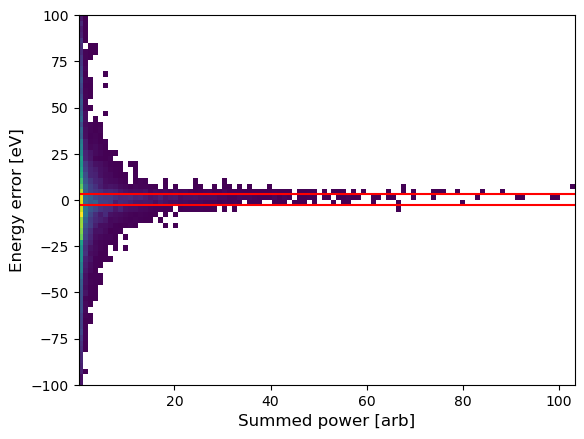

In [90]:
plt.hist2d(max_powers, energy_errs, bins=100, cmin=1)
plt.xlabel("Max power [arb]")
plt.ylabel("Energy error [eV]")
plt.ylim(-100, 100)
plt.axhline(-3, color='r')
plt.axhline(3, color='r')
plt.savefig(CHECKPOINT_folder+"_plots/err_vs_max_power.png")

In [91]:
diff = true_post[:, energy_ind]-pred_post[:, energy_ind]
mask = abs(diff) < 3 # current definition of "well reconstructed events"

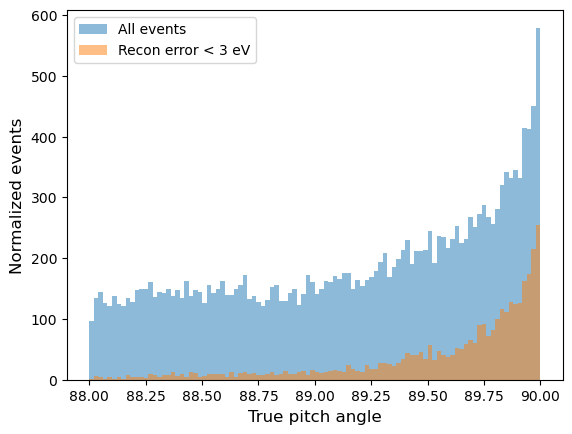

In [92]:
n, bins, _ = plt.hist(true_post[:, pitch_ind], bins=100, label="All events", alpha=0.5)
h = plt.hist(true_post[mask, pitch_ind], bins=bins, label="Recon error < 3 eV", alpha=0.5)
plt.xlabel("True pitch angle")
plt.ylabel("Normalized events")
plt.legend()
plt.savefig(CHECKPOINT_folder+"_plots/pitchangle_reconerror.png")

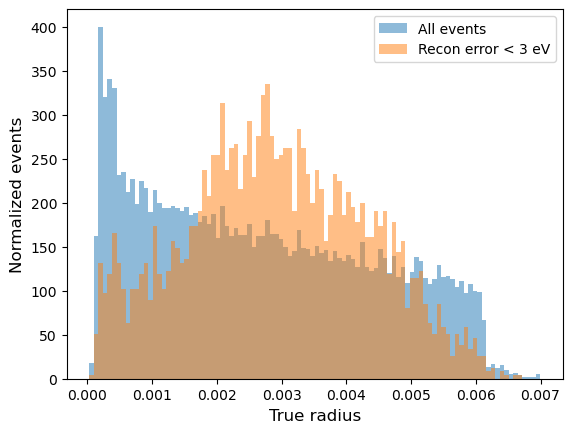

In [93]:
n, bins, _ = plt.hist(meta[:, radius_ind], bins=100, label="All events", density=True, alpha=0.5)
h = plt.hist(meta[mask, radius_ind], bins=bins, label="Recon error < 3 eV", density=True, alpha=0.5)
plt.legend()
plt.xlabel("True radius")
plt.ylabel("Normalized events")
plt.savefig(CHECKPOINT_folder+"_plots/radius_reconerror.png")